In [95]:
from matplotlib import pyplot as plt 
from astropy import units as u
from photutils import DAOStarFinder
from astropy.io import fits
from astropy.visualization import *
from astropy.stats import mad_std
from photutils import * 
from astropy import wcs
import lmfit
from lmfit.lineshapes import gaussian2d, lorentzian

# --- Astronomy Related Packages --- 
from photutils import *
from astropy import units as u
from astropy import wcs
from astropy.io import fits
from astropy.stats import mad_std
from astropy.visualization import *
from astrofyp_functions import *
from astropy.coordinates import Angle, SkyCoord
import astropy.coordinates as coord
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = -1

In [21]:
# --- Plot Parameters ---- 
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams["figure.dpi"] = 100
# plt.rc('font', family = 'serif', serif = 'cmr10') 
# plt.rcParams.update({# Use mathtext, not LaTeX
#                             'text.usetex': True,
#                             # Use the Computer modern font
#                             'font.family': 'serif',
#                             'font.serif': 'cmr10',
#                             'mathtext.fontset': 'cm',
#                             })
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
colour_arrays = ['red', 'blue', 'green', 'crimson', 'lime']

### DAO Starfinder 

In [36]:
def starfinder(data, fwhm, thrs, plot_cond):

    mst_std = mad_std(data)
    daofind = DAOStarFinder(fwhm = fwhm, threshold = thrs*mst_std)
    mst_sources = daofind(data)

    for col in mst_sources.colnames: 
        mst_sources[col].info.format = '%.8g'

    if plot_cond == True: 
        plt.scatter(mst_sources['xcentroid'], mst_sources['ycentroid'], facecolors='none', edgecolors='lime')
        for i in range(0, len(mst_sources)):
            plt.annotate((i + 1), xy = (mst_sources['xcentroid'][i], mst_sources['ycentroid'][i]), fontsize= 5)
        plt.imshow(bochum2_B, vmin = bochum2_B.mean() - bochum2_B.std(), vmax = bochum2_B.mean() + bochum2_B.std(), cmap = 'gist_yarg'); plt.show()
        plt.show()

    return mst_sources

def save_Qtable(Qtable, filename):
    df = Qtable.to_pandas()
    df.to_csv(filename)
    

In [23]:
import os 
os.listdir('astrometric_obs_data/')

['berkeley28_B_wcs.fits',
 'NGC2324_B_wcs.fits',
 'berkeley28_V_wcs.fits',
 '.DS_Store',
 '.thumbs',
 'NGC2324_V_wcs.fits',
 'NGC2355_B_wcs.fits',
 'NGC2355_V_wcs.fits',
 'Bochum2_V_wcs.fits',
 'Bochum2_B_wcs.fits']

## Bochum 2 

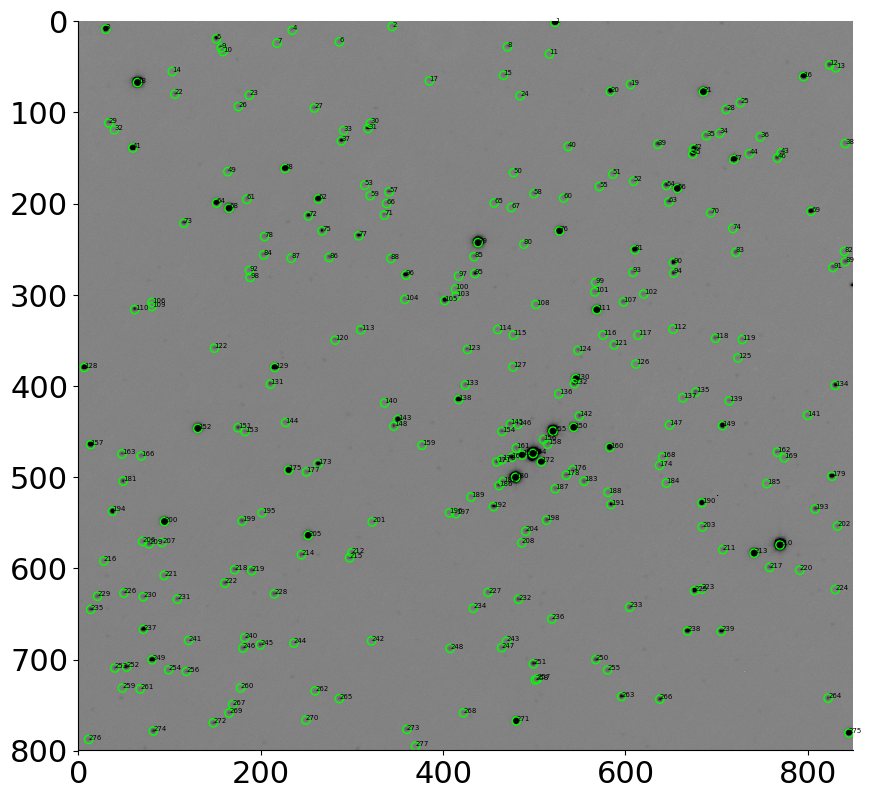

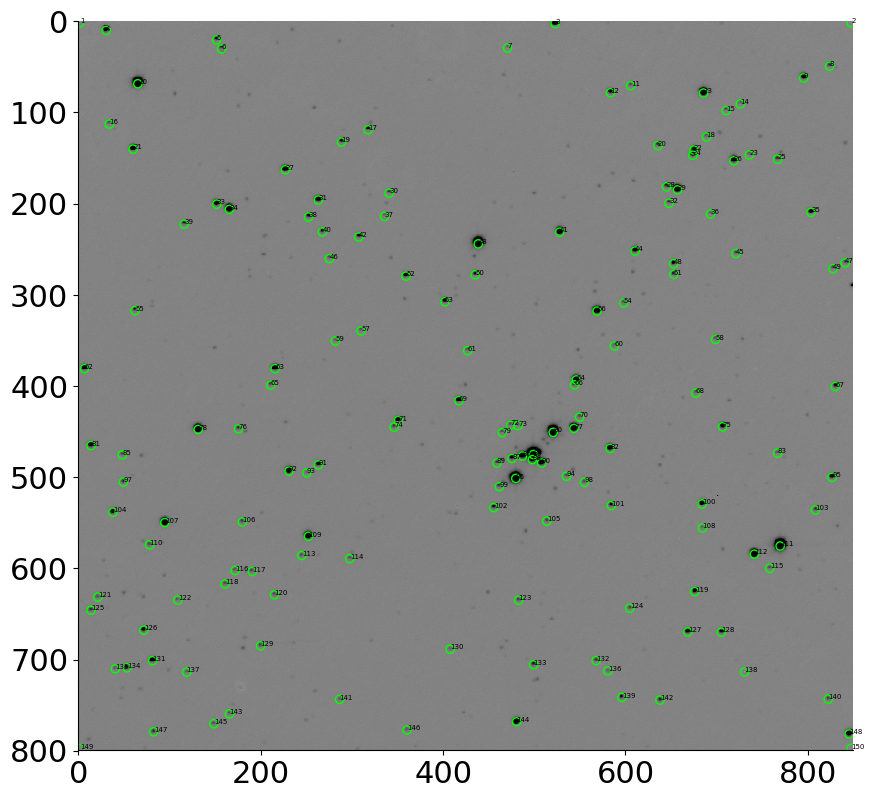

In [50]:
bochum2_B = fits.getdata('processed_data/bochum2_B.fits')
bochum2_sources__B = starfinder(bochum2_B, 3.5, 5, True)
save_Qtable(bochum2_sources__B, 'processed_data/star_detection/bochum2_B.csv')

bochum2_V = fits.getdata('processed_data/bochum2_V.fits')
bochum2_sources__V = starfinder(bochum2_V, 3.9, 5, True)

In [65]:
print(len(bochum2_sources__B), len(bochum2_sources__V))

277 150


### Star Comparison 

In [53]:
def find_nearest(array, value):
    array = np.asarray(array); idx = (np.abs(array - value)).argmin()
    return array[idx], idx

In [136]:
v_sources = bochum2_sources__V; b_sources = bochum2_sources__B

In [119]:
vhdulist = fits.open('astrometric_obs_data/Bochum2_V_wcs.fits')
v_wcs = wcs.WCS(vhdulist[0].header)
x_cordv = v_sources['xcentroid']; y_cordv = v_sources['ycentroid']
v_cord = v_wcs.pixel_to_world(x_cordv, y_cordv)

bhdulist = fits.open('astrometric_obs_data/Bochum2_B_wcs.fits')
x_cordb = b_sources['xcentroid']; y_cordb = b_sources['ycentroid']
b_wcs = wcs.WCS(bhdulist[0].header)
b_cord = b_wcs.pixel_to_world(x_cordb, y_cordb)

vcoord_index = []; bcoord_index = []

v_idx = 0; b_idx = 0 
for cord in v_cord: 
    sep2tar = cord.separation(b_cord).degree
    if sep2tar.min() < 1e-4: 
        vcoord_index.append(v_idx)
        bcoord_index.append(np.argmin(sep2tar))
    b_idx += 1
    v_idx += 1 

v_sources = v_sources[vcoord_index]; b_sources = b_sources[bcoord_index]

## Aperture Photometry 

### Aperture Optimisation 

\begin{equation}
SNR = \dfrac{N^{net}_{star}}{\sqrt{N^{net}_{star}+N_{sky}+N_{noise}}}
\end{equation}

In [188]:
b_sources.argsort(['flux'])

244
138
33
148
210
173
100
98
159
247
273


[769.4537311476605, 574.3176553185843]


Text(0, 0.5, 'Counts')

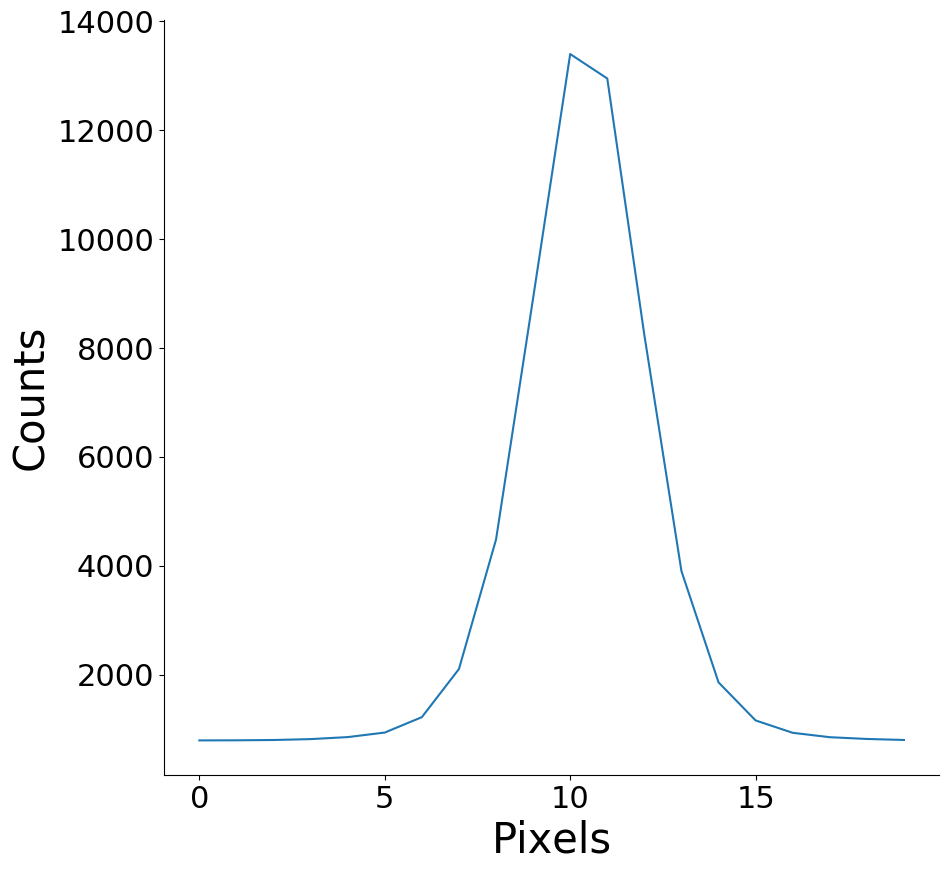

In [202]:
c = b_sources.argsort(['flux'])[-2]
test_stars = [b_sources['xcentroid'][c], b_sources['ycentroid'][c]]
print(test_stars)

image = bhdulist[0].data
x = int(test_stars[0]); y = int(test_stars[1])
plt.plot(image[y, (x-10):(x+10)])
plt.xlabel('Pixels'); plt.ylabel('Counts')

 id  xcenter   ycenter  ... aperture_sum_87 aperture_sum_88 aperture_sum_89
       pix       pix    ...                                                
--- --------- --------- ... --------------- --------------- ---------------
  1 769.45373 574.31766 ...       433061.24       437898.47       442782.82
Bkg Mean: 778.085
4.200000000000003


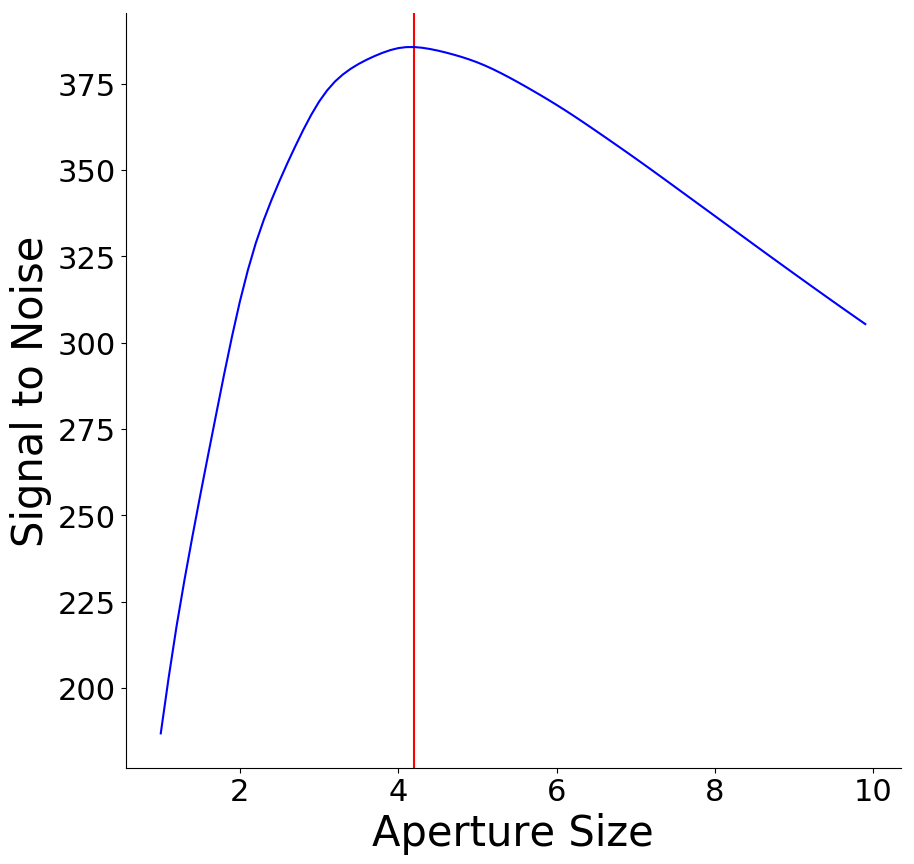

In [206]:
trial_radius = np.arange(1, 10, 0.1) # - trial apertures. 

apertures = [CircularAperture(test_stars, r=r) for r in trial_radius]
phot_table = aperture_photometry(image, apertures)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

bkg_mean = np.mean(image[300:400, 600:640]) # - [x1:x2, y1:y2]
print('Bkg Mean:', '{:.3f}'.format(bkg_mean))

snr = np.array([])
index = 0
for col in phot_table.colnames[3:]:
    bkg_total = bkg_mean * apertures[index].area
    net_star = phot_table[col] - bkg_total
    snr = np.append(snr, net_star / np.sqrt(net_star + bkg_total))
    index += 1

opti_aper = trial_radius[np.argmax(snr)]
print(opti_aper)

plt.axvline(opti_aper, color = 'red')
plt.plot(trial_radius, snr, color = 'blue')
plt.xlabel('Aperture Size'); plt.ylabel('Signal to Noise')
plt.show()    

In [125]:
def aper_photometry(data, sources, fwhm):
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

    # Aperture and Annulus 
    aperture = CircularAperture(positions, r=1.5*fwhm)
    annulus_aperture = CircularAnnulus(positions, r_in = 10, r_out = 15)
    apers = (aperture, annulus_aperture)

    phot_table = aperture_photometry(data, apers)
    # print(annulus_aperture)

    # We calculate the mean counts in each pixel in the background annulus, and the n multiply by the area
    # in the aperture to get the total background counts within each aperture 
    bkg_mean = phot_table['aperture_sum_1']/annulus_aperture.area
    bkg_sum = bkg_mean*aperture.area

    # # Now we get the final table of background subtracted counts within each aperture
    final_sum = phot_table['aperture_sum_0'] - bkg_sum

    return -2.5*np.log10(final_sum)

In [128]:
v_photometry = aper_photometry(vhdulist[0].data, v_sources, 3.9)
b_photometry = aper_photometry(bhdulist[0].data, b_sources, 3.5)

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log10
/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log10


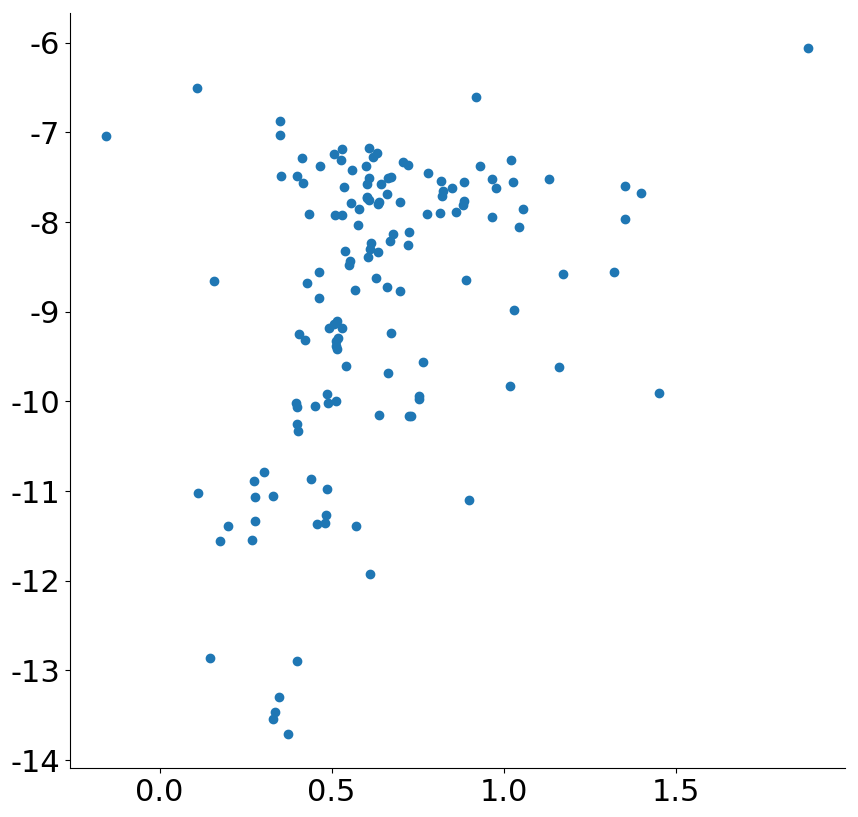

In [131]:
bv = b_photometry - v_photometry
v = v_photometry

plt.scatter(bv, v)